In [1]:
# import all stuff we will need
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.datasets

from numpy.random import randn
from scipy.stats import norm
from scipy.optimize import fmin_slsqp
from scipy.optimize import fsolve
from scipy.interpolate import UnivariateSpline
from call_put_bs import call_put_bs
from min_max import min_max
from implied_vola import implied_vola
from mle_tlocation import mle_tlocation
from scipy.special import gamma
from yf import yf

# 3.1 The principles of option pricing in a nut shell

We proceed with binomial trees from section 2.1 and use them to price options. By constructing a <span style="color:red">risk-free</span> portfolio (long one share of underlying, short $\delta$ call options) we learn that an option price $v_{0,0}$ is a discounted expectation with respect to a so-called martingale measure $\mathbb{Q}$, i.e.,

\begin{equation*}
v_{0,0}=e^{-rT}\mathbb{E}^{\mathbb{Q}}\big[g(S_m)\mid s_{0,0}=s\big]\;.
\end{equation*}

Here, $g$ is the payoff function of the option and $S_m$ is the stock price at maturity. $S_m$ is a discrete random variable; by construction, the distribution of $S_m$ with respect to the measure $\mathbb{Q}$ is

\begin{equation*}
\mathbb{Q}[S_m=s_{i,m}]=\binom{m}{i}{p^\ast}^{i}{q^\ast}^{m-i},\quad i=0,\ldots,m
\end{equation*}

with 

\begin{equation*}
p^\ast := \frac{e^{r\Delta t}-d}{u-d}, \quad q^\ast := \frac{u-e^{r\Delta t}}{u-d}
\end{equation*}

the (risk-neutral) probability of a up- and down movement respectively of the stock in one period. Hence, the above expectation becomes

\begin{equation*}
v_{0,0}=e^{-rT}\mathbb{E}^{\mathbb{Q}}\big[g(S_m)\mid s_{0,0}=s\big]=e^{-rT}\sum_{i=0}^{m}\mathbb{Q}[S_m=s_{i,m}]g(s_{i,m})\;.
\end{equation*}

Note that the above equation is a <span style="color:red">discrete</span> version of the Black-Scholes formula. Indeed, for call option with $g(x)=\max\{x-X,0\}$ for example we find the above expectation to be

\begin{equation*}
v_{0,0}=sB_{m,\widehat{p}}(i^\ast)-Xe^{-rT}B_{m,p^\ast}(i^\ast)\;,
\end{equation*}

where $s=s_{0,0}$ is the current stock price and $B_{n,p}(x)$ denotes the complementary distribution function of the binomial distribution with parameters $n$ and $p$.

As we have seen in section 2.1, the discrete random variable $S_m$ converges (in distribution) to the continuous random variable $S_T$ (as the number of periods $m$ tends to infinity) and the price of the option converges to 

\begin{equation*}
V(s,0)=e^{-rT}\mathbb{E}^{\mathbb{Q}}\big[g(S_T)\mid S_0=s\big]=e^{-rT}\int_0^\infty g(x)f_S(x){\rm d}x\;,
\end{equation*}

where $f_S(x)$ is the (risk-neutral) probability density function of the random variable $S_T$.

# 3.2 The formula of Black and Scholes

In the model of Black and Scholes, the risk-neutral probability density function of $S_T$ starting in $s=S_t$ is

\begin{equation*}
f_S(x)=\frac{1}{\sqrt{2\pi\sigma_S^2}x}e^{-\frac{(\ln(x/s)-\mu_S)^2}{2\sigma^2_S}}\;,
\end{equation*}

with 

\begin{equation*}
\mu_S=(r-q-\frac{1}{2}\sigma^2)(T-t), \quad \sigma_S=\sigma\sqrt{T-t}\;.
\end{equation*}

Equivalently, the log-return $R^c_{t,T}=\ln(S_T/S_t)\sim\mathcal{N}(\mu_S,\sigma_S^2)$ is normal. Hence, by writing

\begin{equation*}
S_T=se^{R^c_{t,T}}
\end{equation*}

the above integral becomes

\begin{equation*}
V(s,0)=e^{-rT}\int_0^\infty g(x)f_S(x){\rm d}x=e^{-rT}\int_{-\infty}^\infty g(se^x)\phi_{\mu_S,\sigma_S}(x){\rm d}x\;.
\end{equation*}

Here, $\phi_{\mu,\sigma}$ denotes the density of the normal distribution with mean $\mu$ and standard deviation $\sigma$. By <span style="color:red">standardising</span> 

\begin{equation*}
z=\frac{x-\mu_S}{\sigma_S}
\end{equation*}

we can calculate the value of <span style="color:red">any</span> european option with payoff $g$ in the Black-Scholes model by

\begin{equation*}
V(s,0)=e^{-rT}\int_{-\infty}^\infty g(se^{\sigma_Sz+\mu_S})\phi(z){\rm d}z\;,\quad \phi(z)=\frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}z^2}\;.
\end{equation*}

Evaluating this integral for a call or a put option with payoff $g(x)=\max\{\omega(x-X),0\}$ ($\omega=1$ for a call, $\omega=-1$ for a put), we obtain the famous <span style="color:red">Black-Scholes formula</span>

\begin{equation*}
V(s,t;X,T,\sigma,r,q,\omega)=\omega\big(se^{-q(T-t)}N(\omega d_1)-Xe^{-r(T-t)}N(\omega d_2)\big)\;.
\end{equation*}


The formula of Black and Scholes is a so-called closed-form solution to the (call) option pricing problem and is only valid under the assumption that the price of the underlying follows a geometric Brownian motion (or equivalently, that the log-returns of the underlying are normal). Naturally, one has to extend the pricing problem in two directions. 


E$_1$) Can we still derive closed-form solutions to price other derivatives than European? An American option for example gives its holder the right to exercise not only at maturity, but at any time during the life time $]0,T]$ of the option. The payoff of an Asian fixed strike option on the other hand depends not just on the value $S_T$ of the underlying at maturity, but on the (discrete) average $A_T=\sum_{j=1}^JS_{t_j}$ over predetermined dates $t_j\in [0,T]$. For both examples (American, discrete fixed strike Asian) there are no closed form solutions such that we have to rely on numerical methods. Barrier options become worthless (or worth-full), if the underlying hits the barrier(s) during the life time of the option. For such options there exist formulas to find their price, but some of them are quit involved (this is in particular true for double barrier options), compare with chapter 4. At this stage, we could name many other types of options/derivatives for which there are no pricing formulas or for which the pricing formulas are too complicated to evaluate them directly (see the example below).  

E$_2$) By now it is well accepted and demonstrated in many empirical studies that the Black-Scholes model is inappropriate to map real stock price/return data. In particular, the model of Black and Scholes assumes normally distributed log-returns, which is not observable in reality. Furthermore, the volatility $\sigma>0$ is not constant (over time) as proposed by the model. Even worse, it seems that volatility itself is stochastic. In section 2.5 we will come back to the short comings of the Black-Scholes model. Due to this mis-modelling people suggested alternative models for the time evolution of stock prices $S_t$ in the sequel. Some of these models are mathematically very demanding and for a larger part of them there are no closed form solutions to the pricing problem, even not for plain vanillas. Again we have to dwell on numerical methods. 

### Example 3.2

We look at an example to E$_1$). The following definition is taken from Heynen and Kat. A <span style="color:red">floating strike lookback</span> option grants its holder the right to buy at the lowest price (when it is a call) or to sell at the highest price (when it is a put) recorded during the lookback period, i.e., the period during which the underlying price is monitored. If the lookback period consists in a discrete set of dates $t_j$ with $0=t_0<t_1<\ldots<t_J\leq T$ the option is said to be discretely monitored. If we denote by $m_{t_0}^{t_J}$ the minimum 

\begin{equation*}
m_{t_0}^{t_J}=\min\{S_{t_0},S_{t_1},\ldots,S_{t_J}\}\;,
\end{equation*}

then the payoff of a call is $\max\{S_T-m_{t_0}^{t_J},0\}$ and the value of a discretely monitored floating strike lookback call option is

\begin{equation*}
V_{c,\textrm{fls}}(s,m,t)=e^{-r(T-t)}\mathbb{E}^\mathbb{Q}\big[\max\{S_T-m_{t_0}^{t_J},0\}\mid S_t=s,\; m_{t_0}^t=m\big]\;.
\end{equation*}

Similarly, the value of the corresponding put is 

\begin{equation*}
V_{p,\textrm{fls}}(s,m,t)=e^{-r(T-t)}\mathbb{E}^\mathbb{Q}\big[\max\{m_{t_0}^{t_J}-S_T,0\}\mid S_t=s,\; m_{t_0}^t=m\big]\;;
\end{equation*}

here, $m_{t_0}^{t_J}$ denotes the maximum of the prices. 

The fictitious product of chapter 1, which pays off the difference 

\begin{equation*}
g(S_{t_0},\ldots,S_{t_J}):=\max\{S_{t_0},\ldots,S_{t_J}\}-\min\{S_{t_0},\ldots,S_{t_J}\}\;,
\end{equation*}

is a portfolio consisting in long one floating strike lookback call and long one floating strike lookback put (both with strike $S_0$), whence its value $V(s,0)$ at inception is

\begin{equation*}
V(s,0)=V_{p,\textrm{fls}}(s,s,0)+V_{c,\textrm{fls}}(s,s,0)\;.
\end{equation*}


If we take the Black-Scholes model for $S_t$, then these expectations can be calculated analytically. For example, for a call there holds the formula

\begin{equation*}
V_{c,\textrm{fls}}(s,s,0)= s\bigg(1-N(\textbf{a};\boldsymbol{\rho}_1,J+1)-\sum_{j=1}^Je^{r(t_j-T)}f_j\bigg)-e^{-rT}s\big(N(\textbf{b};\boldsymbol{\rho}_2,J)-N(\textbf{c};\boldsymbol{\rho}_3,J+1)\big)\;,
\end{equation*}
 
where $N(\textbf{x};\boldsymbol{\rho},d)$ denotes the cdf of the $d$-dimensional standard normal distribution with $d\times d$-correlation matrix $\boldsymbol{\rho}$ evaluated at the point $\textbf{x}=(x_1,\ldots,x_d)$, i.e.,

\begin{equation*}
N(\textbf{x};\boldsymbol{\rho},d)=c_d\int_{-\infty}^{x_d}\cdots\int_{-\infty}^{x_1}e^{-\frac{1}{2}\textbf{y}^\top\boldsymbol{\rho}^{-1}\textbf{y}}\textrm{d}\textbf{y}\;.
\end{equation*}

Typically, the number $J$ of observation dates is large; for the above product we have $J=252$ (equal to the number of business days per year). According to the above formula, we thus need to evaluate a $253$-dimensional integral numerically, since the cdf is not known in closed form. Evaluating high-dimensional integrals to a high precision within an acceptable computation time is very hard; the above pricing formula is of no practical relevance and we need other approximation methods. Here, we use Monte Carlo simulation (which we already did in chapter 1). This is rather simple in this current setting, however we need to be aware that the Monte Carlo price is only approximate.

The function <span style="color:orange">min_max.py</span> realises this.

In [2]:
help(min_max)

Help on function min_max in module min_max:

min_max(s0, sigma, r, q, T, J, w1, w2, n)
    Finds the value v of a financial product which pays off
    
    g = w_1*max(S_{t_0},...,S_{t_J}) - w_2*min(S_{t_0},...,S_{t_J})
    
    at maturity T = t_J. w_1 >= w_2 are positive weights which don't need 
    to sum up to one. The S_{t_i} are daily closing prices of the underlying
    at the J+1 observation dates t_0,t_1,...,t_J. We assume that the time 
    period t_{j+1}-t_j between two observation dates is the same for all j. 
    The underlying is modelled as a geometric Brownian motion 
    
        dS_t = (r-q)*S_t*dt + sigma*S_tdW_t, S_0 = s0 
        
    of which n paths are generated (at t_i) to aproximate v.



The model- and contract parameters are from chapter 1. In particular $s_0=286.10$, $T=358/360$, $J=252$, $\sigma=0.0753$, $r=-0.0063$ and $q=0.0310$. Thus

In [3]:
s0 = 286.1; T = 358/360; J = 252; sigma = 0.0753; r = -0.0063; q = 0.0310; # model- and contract parameters
min_max(s0,sigma,r,q,T,J,1,1,10**6)

33.72543747880139

# 3.3 Shortcomings of the model of Black and Scholes

We are coming back to the model of Black and Scholes and to its in E$_2$) mentioned mismodelling of the underlying, respectively. As already said, in the model of Back and Scholes the realised log-returns are normally distributed. We may test this assumption using real data. To do so, in the figure below we exemplarily have a look on the DAX over the time period $26/11/1990$ to $4/7/2012$ and plot a histogram of the daily log-returns $\ln(s_{t+\Delta t}/s_t)$ for $\Delta t=1/252$ ($s_t$ is the daily closing price of the DAX  at time $t$).

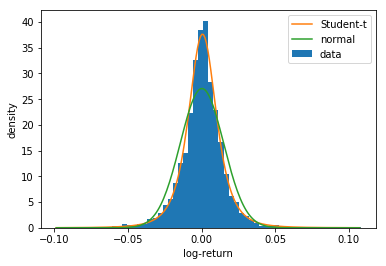

In the same graph, we also plot the probability density function 

\begin{equation*}
\phi_{\mu,\sigma}(x):=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation*}

of the normal distribution $R^c_{t,t+\Delta t}\sim\mathcal{N}(\mu,\sigma^2)$ with $\mu=\overline{r}\doteq 0.000276$ and $\sigma=s_r\doteq 0.014737$ given by the (usual) point estimators for (daily) mean and (daily) standard deviation. We observe that the theoretical distribution (the Black-Scholes model) does not fit the empirical distribution well. In particular, the empirical distribution has heavier tails than the theoretical one which means that the model underestimates the probability of having large absolute returns (large deviations from the mean).

In this regard, the <span style="color:red">Student t</span> distribution does a much better job. Besides the normal distribution, we estimate and plot in the above figure also the probability density function $f_{\mu,\sigma,\nu}$ of the Student t distribution given by  

\begin{equation}\label{eq:density_student_t}
f_{\mu,\sigma,\nu}(x)=c_\nu\frac{1}{\sqrt{\nu\pi}\sigma}\bigg(1+\frac{1}{\nu}\big(\frac{x-\mu}{\sigma}\big)^2\bigg)^{-(\nu+1)/2}\;.
\end{equation}

The above time-series of the DAX log-returns has the estimated parameter values $\mu\doteq 0.00065$, $ \sigma\doteq 0.00983$ and $\nu \doteq 3.2907$; see the technical note on how to get these values using <span style="color:red">maximum likelihood</span> estimation.

Now we consider volatility. We may check the assumption of constant volatility (with respect to strike and time-to-maturity) as follows. We look at market prices 

\begin{equation*}
V_1^{\rm M},\;\;V_2^{\rm M},\;\;\ldots, \;\;V_\nu^{\rm M}
\end{equation*}

(the superscript ${\rm M}$ stands for market) of  $\nu$ traded options on the same underlying with different strikes 

\begin{equation*}
X_1,\;\;X_2,\;\;\ldots, \;\;X_\nu
\end{equation*}

but the same time-to-maturity $T-t$. Since up to the volatility all the model parameters are known we may ask for the volatility $\sigma_\ell$  which, inserted into the formula of Black and Scholes, yields the market value $V_\ell^{\rm M}$ of the $\ell$-th option in the data set. In other words, for each option in the data set we are looking for $\sigma_\ell$ such that  

\begin{equation*}
V(s,t;X_\ell,T,\sigma_\ell,r,q,\omega)=V_\ell^{\rm M}\;.
\end{equation*}

The volatility satisfying this equation is called <span style="color:red">implied volatility</span>. Mathematically, we have to find the root of the function

\begin{equation*}
f(\sigma):=V(s,t;X,T,\sigma,r,q,\omega)-V^{\rm M}
\end{equation*}

where $V(s,t;X,T,\sigma,r,q,\omega)$ indicates the Black-Scholes formula of a call ($\omega=1$) or put ($\omega=-1$) and where $V^{\rm M}$ is the market price of the option. Note that we are not able to solve $f(\sigma)=0$ analytically, such that we have to rely on a numerical procedure. We apply the so-called <span style="color:red">Newton method</span> to solve an equation of the form 


$$f(x)=0.$$ 


Let $x^\ast$ be the (unique) root of $f$. Since we do not know the intersection $(x^\ast,0)$ of the graph of $f$ and  the $x$-axis, we replace the graph $f$ by the tangent $t_0$ at a yet to be determined point $P_0(x_0,f(x_0))$ and calculate the intersetion of this tangent and the $x$-axis, compare with the figure below.

<img src="graph_newton_method.JPG" alt="Drawing" style="width: 300px;"/>


It is easy to calculate the root of $t_0$, since we just need to solve a linear equation. Indeed, the equation of the tangent $t_0$ is 

\begin{equation*}
t_0(x)=f'(x_0)(x-x_0)+f(x_0)\;,
\end{equation*}

its root (we call it $x_1$) solves $t_0(x)=0$, whence

\begin{equation*}
f'(x_0)(x-x_0)+f(x_0)=0\Rightarrow x=:x_1=x_0-\frac{f(x_0)}{f'(x_0)}\;.
\end{equation*}

Obviously, $x_1$ is not equal to $x^\ast$, but hopefully closer to it than $x_0$. If $x_0$ is an approximation to $x^\ast$, then $x_1$ is a better one and it becomes clear how to obtain even better approximations. We just look at the tangent $t_{1}$ at the point $P_{1}(x_{1},f(x_{1}))$ and calculate its root (which we call $x_2$) by 

\begin{equation*}
f'(x_1)(x-x_1)+f(x_1)=0\Rightarrow x=:x_2=x_1-\frac{f(x_1)}{f'(x_1)}\;.
\end{equation*}

Then we proceed in the same manner. Using $x_2$, we obtain $x_3$, out of this then $x_4$ and so on. This leads to Newton's method to solve an equation of the form $f(x)=0$. Choose an initial guess $x_0$ and then successively build the sequence 

\begin{equation*}
(x_0,x_1,x_2,x_3,x_4,\ldots)
\end{equation*}

of approximations to $x^\ast$ by 

\begin{equation*}
x_{k+1}=x_k-\frac{f(x_k)}{f'(x_k)}\;,\quad k=0,1,2,3\ldots.
\end{equation*}

If the function $f$ satisfies certain conditions then the sequence of approximations converges to $x^\ast$, i.e., 

\begin{equation*}
\lim_{k\rightarrow \infty} x_k=x^\ast\;.
\end{equation*}

In practice, we obviously only can calculate a finite sequence $(x_0,x_1,x_2,\ldots, x_n)$ and thus can not obtain  $x^\ast$ exactly (which is however not necessary). How large $n$ should be depends on how close on $x^\ast$ the approximation $x_n$ should be. For example, we might stop the calculation of a new approximation whenever the distance $|x_{k+1}-x_k|$ between to consecutive approximations becomes smaller than some predefined tolerance $\textrm{tol}$.

To find the implied volatility with Newton's method, we have to state the derivative of 
$f(\sigma)=V(s,t;X,T,\sigma,r,q,\omega)-V^{\rm M}$ with repsect to $\sigma$. This derivative is called 'vega' and given by 


\begin{equation*}
f'(\sigma)=\partial_\sigma V(s,t;X,T,\sigma,r,q,\omega)=se^{-q(T-t)}\sqrt{T-t}\phi(d_1)\;.
\end{equation*}

Note that vega is the same for call and put options. 

We realise the calculation of the implied volatiltiy using Newton's method in the function <span style="color:orange">implied_vola.py</span>.    

### Example 3.3

We calculate the implied volatility of the call option with strike $X = 76$ and market price $V^{\rm M} = 6.23$. Since there holds $s = 77.45$, $T − t = 99/360$, $r = -0.0081$ and $q = 0$ we find

In [4]:
help(implied_vola)
s = 77.45; # the price of the underlying
T = yf((11,9,2019),[(20,12,2019)])[0]; r = -0.0081; q = 0; # time-to-maturity, cc risk-free
implied_vola(6.23,s,76,T,r,q,1,0.5)

Help on function implied_vola in module implied_vola:

implied_vola(VM, s, X, T, r, q, omega, init)
    Gives the implied volatility of a call (omega = 1) or put (omega = -1)
    option with market price VM, strike X and maturity T.
    The price of the underlying is s; r and q are cc risk free and cc 
    dividend yield, respectively.



0.3468833779533675

Now repeat the above for all options under consideration. Here is the data

In [5]:
# download option data for U-Blox: data as of September 11, 2019
#df = pd.read_html('https://www.eurexchange.com/exchange-en/market-data/statistics/market-statistics-online/100!onlineStats?productGroupId=9772&productId=1597674&viewType=3&cp=Call&month=12&year=2019&busDate=20190911')
# save the downloaded data
#df = df[0]; df = df[:-1]; df.to_pickle("ublox") 

# load the downloaded data
df = pd.read_pickle("ublox")
df

,Strike price,Version number,Opening price,Daily high,Daily low,Last price,Daily settlem. price,Traded contracts,Open interest,Open interest (adj.)
0,0.01,0.0,0.0,0.0,0.0,0.0,77.44,0,0,0
1,48.00,0.0,0.0,0.0,0.0,0.0,29.57,0,0,0
2,50.00,0.0,0.0,0.0,0.0,0.0,27.62,0,0,0
3,52.00,0.0,0.0,0.0,0.0,0.0,25.67,0,0,0
4,56.00,0.0,0.0,0.0,0.0,0.0,21.88,0,0,0
5,60.00,0.0,0.0,0.0,0.0,0.0,18.21,0,0,0
6,64.00,0.0,0.0,0.0,0.0,0.0,14.73,0,0,0
7,68.00,0.0,0.0,0.0,0.0,0.0,11.51,0,4,4
8,72.00,0.0,0.0,0.0,0.0,0.0,8.66,0,0,0
9,76.00,0.0,0.0,0.0,0.0,0.0,6.23,0,0,0


In [6]:
df = df[['Strike price','Daily settlem. price']].astype(float)
D = df.values
D = D[D[:,0]>=1] # do not take all values to fit the model
X = D[:,0]; VM = D[:,1]

Find the implied volatilities for the options in df.

In [7]:
vola_i = np.zeros(len(D))
vola_i[0] = implied_vola(D[0,1],s,D[0,0],T,r,q,1,0.6);
for j in range(1,len(D)):
    vola_i[j] = implied_vola(VM[j],s,X[j],T,r,q,1,vola_i[j-1]);

vola_i

array([0.50370862, 0.48556632, 0.46447264, 0.43892689, 0.41479637,
       0.39377892, 0.37492644, 0.36004817, 0.34688338, 0.33817546,
       0.33619289, 0.33769768, 0.34224473, 0.34779472])

Now plot the points $(X_\ell,\sigma_\ell^{\rm i})$. 

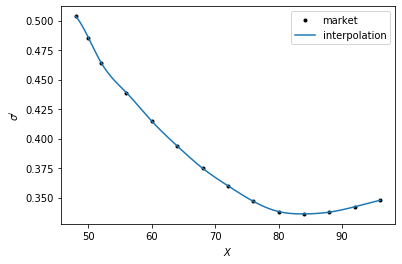

In [8]:
plt.plot(X,vola_i,'k.'); 

f = UnivariateSpline(X,vola_i,k=3,s=0); 
Xvec = np.arange(np.min(X),np.max(X)+0.01,0.01)

plt.plot(Xvec,f(Xvec));
plt.xlabel('$X$'); plt.ylabel('$\sigma^i$');
plt.legend(('market','interpolation'));

Note that between these points we use some interpolation procedure: for a not tradable option with strike $X\in ]X_\ell,X_{\ell+1}[$ we stipulate an implied volatility by some function $f$, $X\mapsto \sigma^{\textrm{i}}=f(X)$. In particular, $f$ defines indirectly a price for options that are not available on the market through the Black-Scholes formula 

\begin{equation*}
X\mapsto V(s,t;X,T,\sigma^{\textrm{i}},r,q,\omega)=V(s,t;X,T,f(X),r,q,\omega)\;.
\end{equation*}

Here, we have to be careful, since the map $X\mapsto V$ is convex or, equivalently, the so-called dual-gamma of the option is not negative, that is 

\begin{equation*}
\partial_{XX}V(s,t;X,T,f(X),r,q,\omega)=\frac{ e^{-r(T-t)}\phi(d_2)}{Xf(X)\sqrt{T-t}}\big(1+\chi(X)\big)\geq 0\;.
\end{equation*}

If the interpolation function $f$ implies a violation of the convexity, there are arbitrage opportunities (so-called butterfly arbitrage) and the model $f$ is not a good model.

In [ ]:
Check the butterfly-arbitrage condition $\partial_{XX}V\geq 0$ for the above data.

In [9]:
V = lambda x:call_put_bs(s,x,T,f(x),r,q,1) # the option price V; for later purpose

f_x = f.derivative(1); f_xx = f.derivative(2) # the derivatives of f

# get the aux function chi(X)
d1 = lambda x:(np.log(s/x)+(r-q+f(x)**2/2)*T)/(f(x)*np.sqrt(T))
d2 = lambda x:d1(x)-f(x)*np.sqrt(T)
chi = lambda x:2*np.sqrt(T)*x*d1(x)*f_x(x)+T*d1(x)*d2(x)*x**2*f_x(x)**2+T*x**2*f(x)*f_xx(x)

# get the dual-gamma
V_XX = lambda x:np.exp(-r*T)*norm.pdf(d2(x))/(x*f(x)*np.sqrt(T))*(1+chi(x))

5.470369325280785

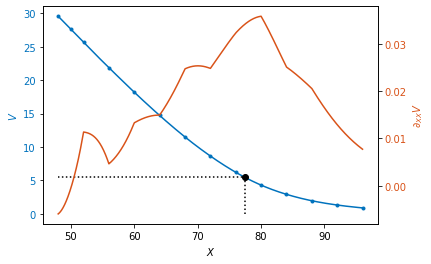

In [10]:
# plot option price and its dual-gamma

fig, ax1 = plt.subplots()
color = (0,0.4470,0.7410)
ax1.plot(Xvec,V(Xvec),color=color), ax1.plot(X,VM,'.',color=color)
ax1.plot([s,s,np.min(X)],[0,V(s),V(s)],'k:'), ax1.plot(s,V(s),'ko')
ax1.set_xlabel('$X$'), ax1.set_ylabel('$V$',color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()

color = (0.85,0.325,0.098)
ax2.plot(Xvec,V_XX(Xvec),color=color);
ax2.set_ylabel('$\partial_{XX}V$',color=color)
ax2.tick_params(axis='y',labelcolor=color)

V(s) # the value of a ATM call according to the 'model' f

# 3.4 Alternatives to the model of Black and Scholes

As long as we are concerned with the pricing of European put or call options there is nothing wrong with the Black-Scholes formula. We just take for the volatility $\sigma$ the implied volatility $\sigma^{\rm i}(X,T)$ depending on the strike $X$ and on the time-to-maturity $T$ of the option to be priced. As we have seen, the market only quotes implied volatilities for options which are available on the market. However, we need to price options with any strike or maturity. For example, how do we price an option with strike $1.12S_0$ and maturity $T=5$ years if the listed strikes are $0.9S_0$, $0.98S_0$, $1.05S_0$, $1.2S_0$ and the longest listed maturity is two years? A naive answer would be that we obtain the implied volatility $\sigma^{\rm i}(1.12S_0,5)$ by some interpolation and/or extrapolation applied to quoted implied volatilities. This is, however, not a good advice, since these inter- and/or extrapolations are generally not free from arbitrage. While it is possible to eliminate arbitrage implied by interpolation, extrapolation is more subtle. Thus, we typically have to resort on implied volatility models; these models are linked to the notion of local volatility. This is a model which extends the Black-Scholes model and which is used to price some standard exotic options such as digitals, barrier, Asian or lookback options.

## Local volatility

In the local volatility model the volatility is a deterministic function of time $t$ and level of the underlying

\begin{equation*}
\sigma=\sigma(s,t)
\end{equation*}
  
for some bivariate, deterministic function $\sigma:\mathbb{R}^+\times [0,T]\rightarrow \mathbb{R}^+$. We replace in the stochastic differential equation of a geometric Brownian motion the constant $\sigma$ by $\sigma(s,t)$ and obtain the so-called <span style="color:red">local volatility</span> model, that is,

\begin{equation*}
{\rm d}S_t=\mu S_t{\rm d}t+\sigma(S_t,t) S_t {\rm d}W_t,\quad S_0=s>0\;.
\end{equation*}

The natural question is: does there exist a bivariate function $(s,t)\mapsto \sigma(s,t)$ such that the prices $V_c(s,0;X,T)$ of European (call) options implied by the above model are equal to the market prices, i.e., such that for every strike $X$ and every time-to-maturity $T$ the equation 

\begin{equation*}
V_c(s,0;X,T)=V^\textrm{M}(s,0;X,T)
\end{equation*}

becomes true? The answer to this question was given by Bruno Dupire and is "yes". 

Once the question of the existence of such a function is answered we ask for the construction of it. Dupire shows: if there are available market prices $V_c(X,T)$ of (call) options (we skip the dependence on $s$) for a continuum of strikes $X$ and times-to-maturity $T$, then the function $\sigma$ is given by  

\begin{equation*}
\sigma^2(X,T)=2\frac{\partial_TV_c(X,T)+(r-q)X\partial_XV_c(X,T)+qV_c(X,T)}{X^2\partial_{XX}V_c(X,T)}\;.
\end{equation*}

In practice, however, we only have available a finite set of market prices which means that the function $V_c(X,T)$ and its partial derivates are not known. Thus, we need interpolation as well as extrapolation tools such that

- the partial derivatives $\partial_TV_c$, $\partial_XV_c$ and $\partial_{XX}V_c$ appearing in the above fraction exist and such that
- there exist no arbitrage opportunities.

How do we construct the local volatility function $\sigma$ above when there are only a finite number of market prices $V_c(X_j,T_j)$ available? Several approaches to construct $\sigma$ are discussed in the scientific literature, we briefly describe the approach of Gatheral and Jaquier. The authors do not directly consider the  above equation/definition, but a transformed version of it. To be more precise, we do not consider option prices $V$ but so called total implied variances $w$, defined as

\begin{equation*}
w(x,T) := \big(\sigma^{\textrm{i}}(x,T)\big)^2T\;.
\end{equation*}

Herein, $\sigma^{\textrm{i}}(x,T)$ denotes the implied volatility of a European call or put option with strike

\begin{equation*}
X = S_0e^{(r-q)T}e^x
\end{equation*}

and time-to-maturity $T$. Thus, we need to re-express the above equation for the local volatility function in terms of $w$. It is possible to show (for simplicity we skip the argument $(x,T)$ in $w(x,T)$)

\begin{equation*}
\sigma^2(F_Te^x,T)=\frac{\partial_T w}{\big(\frac{x}{2w}\partial_xw-1\big)^2+\frac{1}{2}\partial_{xx}w-\frac{1}{4}\big(\frac{1}{4}+\frac{1}{w}\big)(\partial_xw)^2}\;.
\end{equation*}

The next step in the construction of the local volatility function $\sigma(x,T)$ is the specification of $w$. For a fixed time-to-maturity $T$, Gatheral assumes a parametric form for the total implied variance. To be more precise, he assumes that - for a vector of parameters $\boldsymbol{\eta}:=(a,b,\rho,m,s)$ - the function $x\mapsto w(x)$ takes the form

\begin{equation*}
w(x;\boldsymbol{\eta}) := a+b\Big(\rho(x-m)+\sqrt{(x-m)^2+s^2}\Big)\;.
\end{equation*}

Herein, $a,m\in\mathbb{R}$, $b\geq 0$, $-1\leq\rho\leq 1$, and $s>0$ are parameters to be found. Since $w$ is a total variance, it can not be negative, $w(x;\boldsymbol{\eta})\geq 0$ for all $x\in\mathbb{R}$, thus the parameters have to satisfy the additional constraint  

\begin{equation*}
a+bs\sqrt{1-\rho^2}\geq 0\;.
\end{equation*}

There is no butterfly-arbitrage iff the denominator is non-negative, i.e.,

\begin{equation*}
\psi(x;\boldsymbol{\eta}):=\Big(\frac{x}{2w(x;\boldsymbol{\eta})}\partial_xw(x;\boldsymbol{\eta})-1\Big)^2+\frac{1}{2}\partial_{xx}w(x;\boldsymbol{\eta})-\frac{1}{4}\Big(\frac{1}{4}+\frac{1}{w(x;\boldsymbol{\eta})}\Big)\big(\partial_xw(x;\boldsymbol{\eta})\big)^2\geq 0
\end{equation*}

Now suppose we would like to price an European put or call with time-to-maturity $T$ and strike $X$. Also suppose that we have available markets quotes $V_\ell^{\textrm{M}}$ of European options with time-to-maturity equal to $T$ and strikes $X_\ell\neq X$, $\ell=1,2,\ldots,\nu$.

The question is then: How do we calibrate the model $w(x;\boldsymbol{\eta})$ such that the butterfly-arbitrage condition $\psi(x;\boldsymbol{\eta})\geq 0$ is satisfied? The answer leads to a sophisticated regression problem. The details presented in the script show that the parameter vector $\boldsymbol{\eta}$ is solution to the constrainted non-linear minimisation problem

\begin{equation*}
\widehat{\boldsymbol{\eta}}:=\underset{\boldsymbol{\eta}\in\mathcal{S}}{\operatorname{argmin}}\sum_{\ell=1}^\nu\Big[w(x_\ell;\boldsymbol{\eta})-(\sigma^{\textrm{i},\textrm{M}}_\ell)^2T\Big]^2+\lambda \sum_{j=0}^N1_{\{\psi(x_j;\boldsymbol{\eta})<0\}}\;.
\end{equation*}

where the set $\mathcal{S}\subset\mathbb{R}^5$ is defined by

\begin{equation*}
\mathcal{S}:=\Big\{\boldsymbol{\eta}\in\mathbb{R}^5\mid b\geq 0,\;s>0,\;|\rho|\leq 1,\;a+bs\sqrt{1-\rho^2}\geq 0\Big\}\;.
\end{equation*}

Furthermore, the $x_j$'s, $j=1,\ldots,N$, are the elements of the discrete set $\mathcal{G}:=\{x_1,x_2,\ldots,x_N\}\subset \mathbb{R}$.

## Example 3.5

Take the U-Blox data again and solve the above defined least-squares problem.

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.6645425158397805e-06
            Iterations: 64
            Function evaluations: 475
            Gradient evaluations: 64


array([-0.09840537,  0.19538578,  0.13128531,  0.1908742 ,  0.66952892])

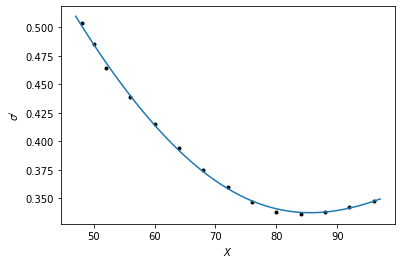

In [11]:
# estimate the model w(x;eta), where eta = [a,b,rho,m,s], using non-linear least squares
wdata = vola_i**2*T; # total implied variances
xdata = np.log(D[:,0]/(s*np.exp(r*T)))

def w_model(eta,x):
    # the total implied variance w(x;eta)
    return  eta[0]+eta[1]*(eta[2]*(x-eta[3])+np.sqrt((x-eta[3])**2+eta[4]**2))

def wp_model(eta,x):
    # the first derivative of w(x;eta) w.r.t x
    return eta[1]*eta[2]+eta[1]*(x-eta[3])/np.sqrt((x-eta[3])**2+eta[4]**2)

def wpp_model(eta,x):
    # the second derivative of w(x;eta) w.r.t x
    return eta[1]*eta[4]**2*((x-eta[3])**2+eta[4]**2)**(-3/2)

def psi(eta,x):
    # the function psi(x;eta)
    return (x/(2*w_model(eta,x))*wp_model(eta,x)-1)**2+0.5*wpp_model(eta,x)\
            -0.25*(0.25+1/w_model(eta,x))*wp_model(eta,x)**2

def obj_func(eta): 
    # the objective function to be minimized; 
    lam = 10**10; # penalty parameter
    residuals = wdata-w_model(eta,xdata) # the residuals
    x = np.arange(-5,5,10**(-3)); y = psi(eta,x);
    penalty = lam*np.sum(y<0) # if psi(x) < 0, penalize
    
    return np.sum(residuals**2)+penalty

eta0 = np.array([-0.3,0.2,0.3,0,0.4])
eta = fmin_slsqp(obj_func,eta0,eqcons=(),f_eqcons=None,ieqcons=(),
                     f_ieqcons=lambda eta:eta[0]+eta[1]*eta[4]*np.sqrt(1-eta[2]),
                     bounds=((None,None),(0,None),(-1,1),(None,None),(0,None)),
                     fprime=None,fprime_eqcons=None, fprime_ieqcons=None,
                     args=(),iter=1000, acc=1e-15, iprint=1, disp=None, full_output=0)

plt.plot(D[:,0],vola_i,'k.');
x = np.arange(0.98*np.min(D[:,0]),1.02*np.max(D[:,0]),1)
plt.plot(x,np.sqrt(w_model(eta,np.log(x/(s*np.exp(r*T))))/T));
plt.xlabel('$X$'); plt.ylabel('$\sigma^i$');

eta

Check the condition $\psi(x)\geq 0$ graphically and find the minimum of $\psi$ over the set $\mathcal{G}$.

0.06495441876302245

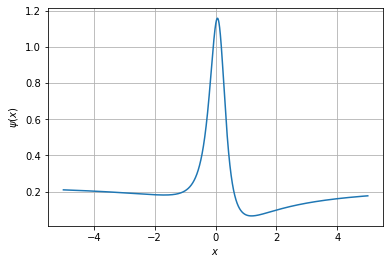

In [12]:
x = np.arange(-5,5,10**(-4)); plt.plot(x,psi(eta,x)); plt.grid()
plt.xlabel('$x$'); plt.ylabel('$\psi(x)$');

np.min(psi(eta,x))

Now, compare the model $w$ with the cubic spline interpolation $f$

In [13]:
lm = lambda x:np.log(x/s)-(r-q)*T  # the log-moneyness
g = lambda x:np.sqrt(w_model(eta,lm(x))/T)
d1g = lambda x:(np.log(s/x)+(r-q+g(x)**2/2)*T)/(g(x)*np.sqrt(T))
d2g = lambda x:d1g(x)-g(x)*np.sqrt(T)
Vg = lambda x:call_put_bs(s,x,T,g(x),r,q,1)

5.49709374614504

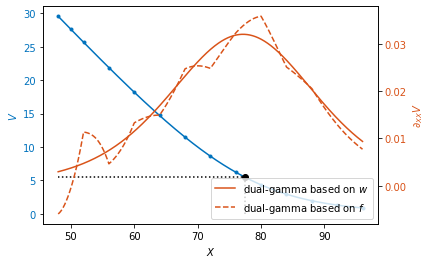

In [14]:
# plot option price and its dual-gamma

fig, ax1 = plt.subplots()
color = (0,0.4470,0.7410)
ax1.plot(Xvec,Vg(Xvec),color=color), ax1.plot(X,VM,'.',color=color)
ax1.plot([s,s,np.min(X)],[0,Vg(s),Vg(s)],'k:'), ax1.plot(s,Vg(s),'ko')
ax1.set_xlabel('$X$'), ax1.set_ylabel('$V$',color=color)
ax1.tick_params(axis='y',labelcolor=color)

ax2 = ax1.twinx()

color = (0.85,0.325,0.098); h = 0.001
ax2.plot(Xvec,(Vg(Xvec-h)-2*Vg(Xvec)+Vg(Xvec+h))/h**2,color=color);
ax2.plot(Xvec,V_XX(Xvec),'--',color=color);
ax2.set_ylabel('$\partial_{XX}V$',color=color)
ax2.tick_params(axis='y',labelcolor=color)
plt.legend(('dual-gamma based on $w$','dual-gamma based on $f$'));

Vg(s) # the value of a ATM call according to the model w

As the difference between the option prices implied by $f$ and the option prices implied by $w$ are not visible in the above graph, we plot the relative difference

\begin{equation*}
\frac{|V(X;f)-V(X;w)|}{V(X;f)}
\end{equation*}

in seperate figure. The dots corresponds to the market quotes.

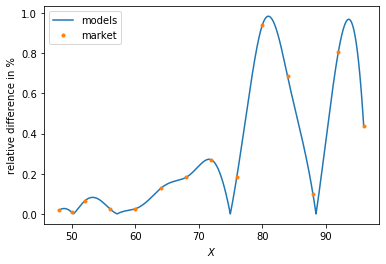

In [15]:
plt.plot(Xvec,np.abs(Vg(Xvec)-V(Xvec))/V(Xvec)*100)
plt.plot(X,np.abs(Vg(X)-V(X))/V(X)*100,'.');
plt.legend(('models','market'))
plt.xlabel('$X$'); plt.ylabel('relative difference in %');

In [ ]:
As we have calibrated the model $w$ to market quotes, we are able to solve the problem of example 1.1, iii): On September 11, 2019 ($t=0$) find the strike $X$ of a European call option on U-Blox which expires on December 20, 2019 $(t=T)$ such that $V_c(s,0;X)=2.75$. 

In [16]:
# find the strike X such that Vc(s;X) - 2.75 = 0
f = lambda x: call_put_bs(s,x,T,g(x),r,q,1)[0]
X2 = fsolve(lambda x:f(x)-2.75,80)[0]

X2

84.70345936444603

Now we repeat drawing the profit diagram of the outperformance product in example 1.1, iii).

In [17]:
# the implied vola and the price of calls with strike X1 and X2, respectively
X1 = 1.0*s; x = np.asarray([[X1,X2]])
prices = call_put_bs(s,x,T,g(x),r,q,1)[0]
g(x), prices

(array([[0.34465034, 0.33733884]]), array([5.49709375, 2.75      ]))

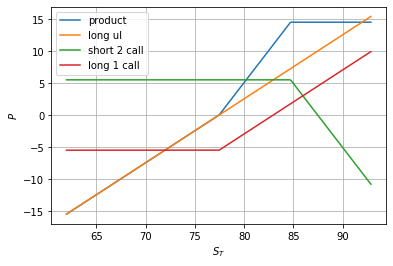

In [18]:
n_long = 1; n_short = 2; # 'n_long' long call with strike X1, 'n_short' short call with strike X2

# draw the profit diagram of the outperformance product
V0 = s+n_long*prices[0]-n_short*prices[1]
profit = lambda x,X1,X2,V0: x+n_long*np.maximum(x-X1,0)-n_short*np.maximum(x-X2,0)-V0;
x = np.arange(0.8*s,1.2*s,0.1);
plt.plot(x,profit(x,X1,X2,V0)); plt.plot(x,x-s);
plt.plot(x,-n_short*np.maximum(x-X2,0)+n_short*prices[1]);
plt.plot(x,n_long*np.maximum(x-X1,0)-n_long*prices[0]); plt.grid()
plt.legend(['product','long ul','short %i call' %n_short,'long %i call'%n_long])
plt.xlabel('$S_T$'), plt.ylabel('$P$');

## Stochastic volatility

The model of local volatility is used to price some standard exotic options like digitals, barrier, asian or lookback options. However, to price other exotics like forward start or cliquet options a local volatility model is not appropriate. Here, it is market practice to use so-called <span style="color:red">stochastic volatility</span>  models. In such a model, the constant volatility $\sigma$ in the model of Black and Scholes is replaced by a stochastic process $\sigma_t$, i.e., one considers the stochastic differential equation 

\begin{equation*}
{\rm d}S_t=\mu S_t{\rm d}t+\sigma_t S_t {\rm d}W_t,\quad S_0=s>0\;.
\end{equation*}

There exists a vast number of ways to specify $\sigma_t$, here we pick the model of Heston since this one has become the benchmark stochastic volatility model. Heston sets $\sigma_t=\sqrt{V_t}$ and models the variance $V_t$ by a CIR process. The CIR process is named after Cox, Ingersoll and Ross; they use this process to model interest rates. A CIR process is defined as the solution of the stochastic differential equation 

\begin{equation*}
{\rm d}V_t=\kappa(m-V_t){\rm d}t+\delta\sqrt{V_t}{\rm d}\widetilde{W}_t, \quad V_0=v>0\;,
\end{equation*}
 
with $\kappa,m,\delta>0$. The Brownian motion $\widetilde{W}_t$ driving the variance and the Brownian motion $W_t$ driving the stock price $S_t$ are correlated $\rho\in[-1,1]$. 

We remark that stochastic volatility models are related to the famous discrete time GARCH model (Generalised Autoregressive Conditional Heteroscedasticity). Indeed, if one takes in the GARCH model limits to continuous time, we end up with the model  ${\rm d}V_t=\kappa(m-V_t){\rm d}t+\delta V_t{\rm d}\widetilde{W}_t$, where the parameters $\kappa,m,\delta,\rho$ depend on the GARCH parameters.

# 3.8 Technical note. Maximum likelihood estimation

We assume the log-returns to follow a Student-t distribution with density

\begin{equation*}
f(x)=\frac{c_{\nu}}{\sqrt{\nu\sigma^2\pi}}\bigg[1+\frac{1}{\nu}\big(\frac{x-\mu}{\sigma}\big)^2\bigg]^{-\frac{\nu+1}{2}}
\end{equation*}

with location and scale parameter $\mu\in\mathbb{R},\sigma\in\mathbb{R}^+$ and $\nu\in\mathbb{R}^+$ the degrees of freedom. The constant $c_{\nu}$ is given by $c_{\nu}=\Gamma(\frac{\nu+1}{2})/\Gamma(\nu/2)$. Note that $\mu$ is the mean of the distribution, i.e., $\mu=\mathbb{E}[X]$ provided $\nu>1$. The variance of the distribution is $\textrm{Var}[X]=(\frac{\nu}{\nu-2})^2\sigma^2$, provided $\nu>2$.

Maximum likelihood is a common approach to fit parametric distributions to data. Suppose $\textbf{x}=(x_1,x_2,\ldots,x_n)^\top$ is a random sample of a (univariate) random variable $X$. We assume that the density $f(x;\boldsymbol{\eta})$ of $X$ depends on $m$ parameters $\boldsymbol{\eta}=(\eta_1,\eta_2,\ldots,\eta_m)$. For example, the normal distribution has two parameters, $\boldsymbol{\eta}=(\mu,\sigma)$, and the student t distribution is described by three parameters $\boldsymbol{\eta}=(\mu,\sigma,\nu)$. We select the parameters $\boldsymbol{\eta}$ in such a way that, according to the chosen distribution, the realisation $\textbf{x}$ is most likely to appear. Since $\textbf{x}$ is a random sample, it can be viewed as a realisation of the random vector $\textbf{X}=(X_1,X_2,\ldots,X_n)$, where the $X_i$'s are iid copies of $X$. The random vector $\textbf{X}$ has then density $\prod _kf(x_k;\boldsymbol{\eta})$. For a given and fixed $\textbf{x}$, this is a function on the $m$ variables $(\eta_1,\eta_2,\ldots,\eta_m)$; it is called the likelihood function $L$. Thus, $L$ is given by 

\begin{equation*}%\label{eq:likelihood_general}
L(\textbf{x};\boldsymbol{\eta})=\prod_{k=1}^nf(x_k;\boldsymbol{\eta})\;.
\end{equation*}

We are looking for the parameter vector $\boldsymbol{\eta}$ that maximises $L$. The necessary first order condition for a extremum is that all partial derivatives $\partial_{\eta_i}L$ have to be zero. We assume that the corresponding (in general non-linear) system of $m$ equations

\begin{equation*}%\label{eq:likelihood_system}
\left\{\begin{array}{rcl}
\partial_{\eta_1}L(\textbf{x};\boldsymbol{\eta}) & = & 0 \\
\partial_{\eta_2}L(\textbf{x};\boldsymbol{\eta}) & = & 0 \\
& \vdots &   \\
\partial_{\eta_m}L(\textbf{x};\boldsymbol{\eta}) & = & 0
\end{array}
\right.
\end{equation*}

admits a solution $\widehat{\boldsymbol{\eta}}$. Since is unpleasant to take the derivative of a $n$-fold product, it is more convenient to consider the (natural) logarithm of $L$, the corresponding function is called the log-likelihood function

\begin{equation*}
\ell(\textbf{x};\boldsymbol{\eta}):=\ln L(\textbf{x};\boldsymbol{\eta})=\sum_{k=1}^n\ln f(x_k;\boldsymbol{\eta})\;.
\end{equation*}

Since $x\mapsto \ln x$ is strictly increasing, the solution $\widehat{\boldsymbol{\eta}}$ of the original system is also the solution of 

\begin{equation*}%\label{eq:log-likelihood_system}
\left\{\begin{array}{rcl}
\partial_{\eta_1}\ell(\textbf{x};\boldsymbol{\eta}) & = & 0 \\
\partial_{\eta_2}\ell(\textbf{x};\boldsymbol{\eta}) & = & 0 \\
& \vdots &   \\
\partial_{\eta_m}\ell(\textbf{x};\boldsymbol{\eta}) & = & 0
\end{array}
\right.
\end{equation*}

and vice-versa. How does this system translate to the case when $X$ follows a Student t distribution with density 

\begin{equation*}
f(x_k;\boldsymbol{\eta})=c_\nu\frac{1}{\sqrt{\nu\pi}\sigma}\bigg(1+\frac{1}{\nu}\big(\frac{x_k-\mu}{\sigma}\big)^2\bigg)^{-(\nu+1)/2}
\end{equation*}

and $\boldsymbol{\eta}=(\mu,\sigma,\nu)$? Well, if we denote by $z_k:=\frac{x_k-\mu}{\sigma}$ and if we remark that the logarithm of $f$ is in this case just

\begin{equation*}
\ln f(x_k;\mu,\sigma,\nu)=-\frac{1}{2}\ln\pi+\ln c_\nu-\frac{1}{2}\ln\nu-\ln\sigma-\frac{\nu+1}{2}\ln\big(1+\frac{1}{\nu}z_k^2\big)\;,
\end{equation*}

then is easy to see that log-likelihood function is

\begin{equation*}
\ell(\textbf{x};\mu,\sigma,\nu)=-\frac{n}{2}\ln\pi+n\ln c_\nu-\frac{n}{2}\ln\nu-n\ln\sigma-\frac{\nu+1}{2}\sum_{k=1}^n\ln g_k(\mu,\sigma,\nu)\;.
\end{equation*}

Here, we have set 

\begin{equation*}%\label{eq:def_of_gi}
g_k(\mu,\sigma,\nu):=1+\frac{1}{\nu}z_k^2=1+\frac{1}{\nu}\big(\frac{x_k-\mu}{\sigma}\big)^2
\end{equation*}

to simplify the notation. The system of equations in this particular case becomes  

\begin{eqnarray*}
\partial_{\mu}\ell(\textbf{x};\mu,\sigma,\nu) & = & -\frac{\nu+1}{2}\sum_{k=1}^n\frac{\partial_\mu g_k}{g_k}=0\\
\partial_{\sigma}\ell(\textbf{x};\mu,\sigma,\nu) & = & -\frac{n}{\sigma}-\frac{\nu+1}{2}\sum_{k=1}^n\frac{\partial_\sigma g_k}{g_k}=0\\
\partial_{\nu}\ell(\textbf{x};\mu,\sigma,\nu) & = & n\frac{\partial_\nu c_\nu}{c_\nu}-\frac{n}{2\nu}-\frac{1}{2}\sum_{k=1}^n\ln g_k-\frac{\nu+1}{2}\sum_{k=1}^n\frac{\partial_\nu g_k}{g_k}=0
\end{eqnarray*}

Calculating the partial derivatives $\partial_\nu c_\nu$, $\partial_\mu g_k$, $\partial_\sigma g_k$ and $\partial_\nu g_k$ and doing some algebraic manipulations, we finally obtain the following non-linear system to find the parameter vector $\boldsymbol{\eta} = (\mu,\sigma,\nu)$ corresponding to the student t distribution.

\begin{equation*}
\left\{\begin{array}{rcl}
\displaystyle{\sum_{k=1}^n\frac{z_k}{g_k}}& = & 0 \\
\displaystyle{\frac{1}{n}\sum_{k=1}^n\frac{z_k^2}{g_k}-\frac{\nu}{\nu+1}}& = & 0 \\
\displaystyle{\psi\Big(\frac{\nu+1}{2}\Big)-\psi\Big(\frac{\nu}{2}\Big)-\frac{1}{n}\sum_{k=1}^n\ln g_k} & = & 0
\end{array}\right.
\end{equation*}

with

\begin{equation*}
z_k=\frac{x_k-\mu}{\sigma}, \quad g_k=1+\frac{1}{\nu}z_k^2
\end{equation*}

and where $\psi$ denotes the so-called Psi-function. We use Python's fsolve to solve this non-linear system, see the Python function <span style="color:orange">mle_tlocation.py</span>

In [19]:
help(mle_tlocation)

Help on function mle_tlocation in module mle_tlocation:

mle_tlocation(R)
    Given the log-returns R (a vector of length n) of an asset, 
    x = mle_tlocation(R) with x = [mu,sigma,nu] gives the maximum 
    likelihood estimator of a t-distribution with density 
    
    f(x) = cv/(sqrt(nu*pi)*sigma)*[1+1/nu*((x-mu)/sigma)^2]^(-(nu+1)/2)
    
    where cv = gamma((nu+1)/2)/gamma(nu/2).



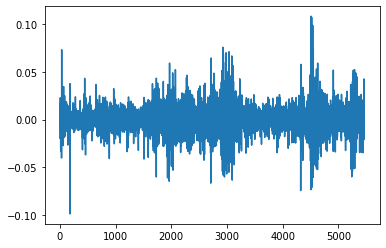

In [22]:
mat_contents = sio.loadmat('DAX.mat')
mat_X = mat_contents['X']
R = np.log(mat_X[1:]/mat_X[0:-1])
plt.plot(R);

Now estimate the parameters $\boldsymbol{\eta}=(\mu,\sigma,\nu)$. 

Note that we could equivalently use <span style="color:orange">eta = st.t.fit(R)</span> from SciPy to obtain $\mu=\textrm{eta[1]}$, $\sigma=\textrm{eta[2]}$ and $\nu=\textrm{eta[0]}$.

In [24]:
eta = mle_tlocation(R); mu = eta[0]; sigma = eta[1]; nu = eta[2];
mu, sigma, nu

(0.0006497316176970825, 0.009829241717685795, 3.2906593797372135)

Plot a histogram of the log-returns and the density $f(x;\mu,\sigma,\nu)$ of the corresponding Student t distribution. For comparison, we also fit and plot the normal distribution. 

In [25]:
# the pdf of the Student t distribution
f = lambda x: gamma((nu+1)/2)/gamma(nu/2)/(np.sqrt(np.pi*nu)*sigma)*(1+1/nu*((x-mu)/sigma)**2)**(-(nu+1)/2)

# for comparison, plot the pdf of the normal distribution fitted to the data
dist = st.norm; args = dist.fit(R)
args

(0.0002757365159879201, 0.014737089975801492)

C:\Users\hino\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


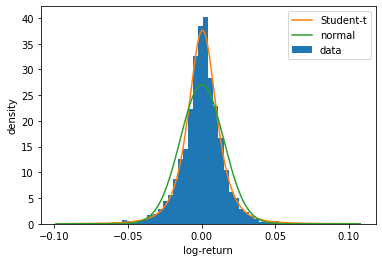

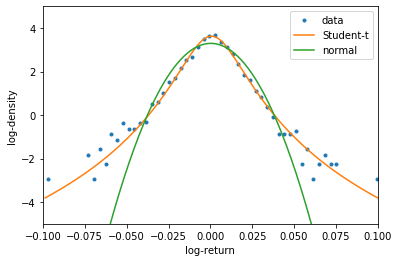

In [26]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(R,60,density=True)
x = np.arange(bins[0],bins[-1],0.001)
ax.plot(x,f(x)); 
ax.plot(x,dist.pdf(x,*args))
plt.xlabel('log-return'); plt.ylabel('density');
plt.legend(('Student-t','normal','data'));

fig, ax1 = plt.subplots()
ax1.plot((bins[1:]+bins[0:-1])/2,np.log(n),marker='.',linestyle='None')
ax1.plot(x,np.log(f(x))); ax1.plot(x,np.log(dist.pdf(x,*args)))
plt.xlabel('log-return'); plt.ylabel('log-density');
plt.legend(('data','Student-t','normal'));
plt.axis([-0.1,0.1,-5,5]);